Training epoch 1
Training loss: 0.9641
Valid acc: 0.7213
Training epoch 2
Training loss: 0.8679
Valid acc: 0.7589
Training epoch 3
Training loss: 0.8132
Valid acc: 0.7880
Training epoch 4
Training loss: 0.7798
Valid acc: 0.7804
Training epoch 5
Training loss: 0.7582
Valid acc: 0.7636
Training epoch 6
Training loss: 0.7432
Valid acc: 0.7759
Training epoch 7
Training loss: 0.7317
Valid acc: 0.7807
Training epoch 8
Training loss: 0.7223
Valid acc: 0.7716
Training epoch 9
Training loss: 0.7147
Valid acc: 0.7810
Training epoch 10
Training loss: 0.7089
Valid acc: 0.7713
Training epoch 11
Training loss: 0.7050
Valid acc: 0.7664
Training epoch 12
Training loss: 0.7010
Valid acc: 0.7765
Training epoch 13
Training loss: 0.6972
Valid acc: 0.7809
Training epoch 14
Training loss: 0.6939
Valid acc: 0.7889
Training epoch 15
Training loss: 0.6911
Valid acc: 0.7760
Final Test acc: 0.7864
Number of trainable parameters:  224892


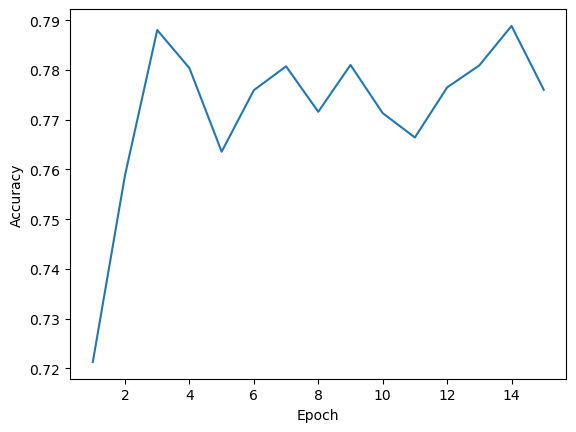

In [ ]:
#!/usr/bin/env python

# Deep Learning Homework 2

import argparse

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt
import numpy as np

import utils

class CNN(nn.Module):
    
    def __init__(self, dropout_prob, no_maxpool=False):
        num_classes = 4
        super(CNN, self).__init__()
        self.no_maxpool = no_maxpool
        if not no_maxpool:
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=0)
            self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            
            self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
            self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

            self.fc_input_features = 400  # Adjust if input size is different
        else:
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1)

            self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=0)

            self.fc_input_features = 576  # Adjust if input size is different
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

        
        self.fc1 = nn.Linear(self.fc_input_features, 320)
        self.relu3 = nn.ReLU()
        self.drop = nn.Dropout(p=0.7)

        self.fc2 = nn.Linear(320, 120)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(120, num_classes)
        self.log_softmax = nn.LogSoftmax()
        
        
    def forward(self, x):
        # input should be of shape [b, c, w, h]
        x = torch.reshape(x, (x.shape[0], 1, 28, 28))
        # conv and relu layers
        x = self.conv1(x)
        x = self.relu1(x)

        # max-pool layer if using it
        if not self.no_maxpool:
            x = self.maxpool1(x)
        
        # conv and relu layers
        x = self.conv2(x)
        x = self.relu2(x)

        # max-pool layer if using it
        if not self.no_maxpool:
            x = self.maxpool2(x)
        
        # prep for fully connected layer + relu
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu3(x)
        
        # drop out
        x = self.drop(x)

        # second fully connected layer + relu
        x = self.fc2(x)
        x = self.relu4(x)
        
        # last fully connected layer
        x = self.fc3(x)
        
        
        return F.log_softmax(x,dim=1)

def train_batch(X, y, model, optimizer, criterion, **kwargs):
    """
    X (n_examples x n_features)
    y (n_examples): gold labels
    model: a PyTorch defined model
    optimizer: optimizer used in gradient step
    criterion: loss function
    """
    optimizer.zero_grad()
    out = model(X, **kwargs)
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()
    return loss.item()


def predict(model, X):
    """X (n_examples x n_features)"""
    scores = model(X)  # (n_examples x n_classes)
    predicted_labels = scores.argmax(dim=-1)  # (n_examples)
    return predicted_labels


def evaluate(model, X, y):
    """
    X (n_examples x n_features)
    y (n_examples): gold labels
    """
    model.eval()
    y_hat = predict(model, X)
    n_correct = (y == y_hat).sum().item()
    n_possible = float(y.shape[0])
    model.train()
    return n_correct / n_possible


def plot(epochs, plottable, ylabel='', name=''):
    plt.clf()
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.plot(epochs, plottable)
    plt.savefig('%s.pdf' % (name), bbox_inches='tight')


def get_number_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def main():
    # parser = argparse.ArgumentParser()
    # parser.add_argument('-epochs', default=20, type=int,
    #                     help="""Number of epochs to train for. You should not
    #                     need to change this value for your plots.""")
    # parser.add_argument('-batch_size', default=8, type=int,
    #                     help="Size of training batch.")
    # parser.add_argument('-learning_rate', type=float, default=0.01,
    #                     help="""Learning rate for parameter updates""")
    # parser.add_argument('-l2_decay', type=float, default=0)
    # parser.add_argument('-dropout', type=float, default=0.7)
    # parser.add_argument('-optimizer',
    #                     choices=['sgd', 'adam'], default='sgd')
    # parser.add_argument('-no_maxpool', action='store_true')
    
    # opt = parser.parse_args()

    class opt:
        epochs = 15
        batch_size = 8
        learning_rate = 0.01
        l2_decay = 0
        dropout = 0.7
        optimizer = 'sgd'
        # no_maxpool = False # Q2.1
        no_maxpool = True # Q2.2

    utils.configure_seed(seed=42)

    data = utils.load_oct_data()
    dataset = utils.ClassificationDataset(data)
    train_dataloader = DataLoader(
        dataset, batch_size=opt.batch_size, shuffle=True)
    dev_X, dev_y = dataset.dev_X, dataset.dev_y
    test_X, test_y = dataset.test_X, dataset.test_y

    # initialize the model
    model = CNN(opt.dropout, no_maxpool=opt.no_maxpool)
    
    # get an optimizer
    optims = {"adam": torch.optim.Adam, "sgd": torch.optim.SGD}

    optim_cls = optims[opt.optimizer]
    optimizer = optim_cls(
        model.parameters(), lr=opt.learning_rate, weight_decay=opt.l2_decay
    )
    
    # get a loss criterion
    criterion = nn.NLLLoss()
    
    # training loop
    epochs = np.arange(1, opt.epochs + 1)
    train_mean_losses = []
    valid_accs = []
    train_losses = []
    for ii in epochs:
        print('Training epoch {}'.format(ii))
        for X_batch, y_batch in train_dataloader:
            loss = train_batch(
                X_batch, y_batch, model, optimizer, criterion)
            train_losses.append(loss)

        mean_loss = torch.tensor(train_losses).mean().item()
        print('Training loss: %.4f' % (mean_loss))

        train_mean_losses.append(mean_loss)
        valid_accs.append(evaluate(model, dev_X, dev_y))
        print('Valid acc: %.4f' % (valid_accs[-1]))

    print('Final Test acc: %.4f' % (evaluate(model, test_X, test_y)))
    # plot
    config = "{}-{}-{}-{}-{}".format(opt.learning_rate, opt.dropout, opt.l2_decay, opt.optimizer, opt.no_maxpool)

    plot(epochs, train_mean_losses, ylabel='Loss', name='CNN-training-loss-{}'.format(config))
    plot(epochs, valid_accs, ylabel='Accuracy', name='CNN-validation-accuracy-{}'.format(config))
    
    print('Number of trainable parameters: ', get_number_trainable_params(model))

if __name__ == '__main__':
    main()


In [1]:
#!/usr/bin/env python

# Deep Learning Homework 2

import argparse

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt
import numpy as np

import utils

class CNN(nn.Module):
    
    def __init__(self, dropout_prob, no_maxpool=False):
        num_classes = 4
        super(CNN, self).__init__()
        self.no_maxpool = no_maxpool
        if not no_maxpool:
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=0)
            self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            
            self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
            self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

            self.fc_input_features = 400  # Adjust if input size is different
        else:
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1)

            self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=0)

            self.fc_input_features = 576  # Adjust if input size is different
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

        
        self.fc1 = nn.Linear(self.fc_input_features, 320)
        self.relu3 = nn.ReLU()
        self.drop = nn.Dropout(p=0.7)

        self.fc2 = nn.Linear(320, 120)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(120, num_classes)
        self.log_softmax = nn.LogSoftmax()
        
        
    def forward(self, x):
        # input should be of shape [b, c, w, h]
        x = torch.reshape(x, (x.shape[0], 1, 28, 28))
        # conv and relu layers
        x = self.conv1(x)
        x = self.relu1(x)

        # max-pool layer if using it
        if not self.no_maxpool:
            x = self.maxpool1(x)
        
        # conv and relu layers
        x = self.conv2(x)
        x = self.relu2(x)

        # max-pool layer if using it
        if not self.no_maxpool:
            x = self.maxpool2(x)
        
        # prep for fully connected layer + relu
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu3(x)
        
        # drop out
        x = self.drop(x)

        # second fully connected layer + relu
        x = self.fc2(x)
        x = self.relu4(x)
        
        # last fully connected layer
        x = self.fc3(x)
        
        
        return F.log_softmax(x,dim=1)

def train_batch(X, y, model, optimizer, criterion, **kwargs):
    """
    X (n_examples x n_features)
    y (n_examples): gold labels
    model: a PyTorch defined model
    optimizer: optimizer used in gradient step
    criterion: loss function
    """
    optimizer.zero_grad()
    out = model(X, **kwargs)
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()
    return loss.item()


def predict(model, X):
    """X (n_examples x n_features)"""
    scores = model(X)  # (n_examples x n_classes)
    predicted_labels = scores.argmax(dim=-1)  # (n_examples)
    return predicted_labels


def evaluate(model, X, y):
    """
    X (n_examples x n_features)
    y (n_examples): gold labels
    """
    model.eval()
    y_hat = predict(model, X)
    n_correct = (y == y_hat).sum().item()
    n_possible = float(y.shape[0])
    model.train()
    return n_correct / n_possible


def plot(epochs, plottable, ylabel='', name=''):
    plt.clf()
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.plot(epochs, plottable)
    plt.savefig('%s.pdf' % (name), bbox_inches='tight')


def get_number_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def main():
    # parser = argparse.ArgumentParser()
    # parser.add_argument('-epochs', default=20, type=int,
    #                     help="""Number of epochs to train for. You should not
    #                     need to change this value for your plots.""")
    # parser.add_argument('-batch_size', default=8, type=int,
    #                     help="Size of training batch.")
    # parser.add_argument('-learning_rate', type=float, default=0.01,
    #                     help="""Learning rate for parameter updates""")
    # parser.add_argument('-l2_decay', type=float, default=0)
    # parser.add_argument('-dropout', type=float, default=0.7)
    # parser.add_argument('-optimizer',
    #                     choices=['sgd', 'adam'], default='sgd')
    # parser.add_argument('-no_maxpool', action='store_true')
    
    # opt = parser.parse_args()

    class opt:
        epochs = 15
        batch_size = 8
        learning_rate = 0.01
        l2_decay = 0
        dropout = 0.7
        optimizer = 'sgd'
        no_maxpool = False # Q2.1
        # no_maxpool = True # Q2.2

    utils.configure_seed(seed=42)

    data = utils.load_oct_data()
    dataset = utils.ClassificationDataset(data)
    train_dataloader = DataLoader(
        dataset, batch_size=opt.batch_size, shuffle=True)
    dev_X, dev_y = dataset.dev_X, dataset.dev_y
    test_X, test_y = dataset.test_X, dataset.test_y

    # initialize the model
    model = CNN(opt.dropout, no_maxpool=opt.no_maxpool)
    
    # get an optimizer
    optims = {"adam": torch.optim.Adam, "sgd": torch.optim.SGD}

    optim_cls = optims[opt.optimizer]
    optimizer = optim_cls(
        model.parameters(), lr=opt.learning_rate, weight_decay=opt.l2_decay
    )
    
    # get a loss criterion
    criterion = nn.NLLLoss()
    
    # training loop
    epochs = np.arange(1, opt.epochs + 1)
    train_mean_losses = []
    valid_accs = []
    train_losses = []
    for ii in epochs:
        print('Training epoch {}'.format(ii))
        for X_batch, y_batch in train_dataloader:
            loss = train_batch(
                X_batch, y_batch, model, optimizer, criterion)
            train_losses.append(loss)

        mean_loss = torch.tensor(train_losses).mean().item()
        print('Training loss: %.4f' % (mean_loss))

        train_mean_losses.append(mean_loss)
        valid_accs.append(evaluate(model, dev_X, dev_y))
        print('Valid acc: %.4f' % (valid_accs[-1]))

    print('Final Test acc: %.4f' % (evaluate(model, test_X, test_y)))
    # plot
    config = "{}-{}-{}-{}-{}".format(opt.learning_rate, opt.dropout, opt.l2_decay, opt.optimizer, opt.no_maxpool)

    plot(epochs, train_mean_losses, ylabel='Loss', name='CNN-training-loss-{}'.format(config))
    plot(epochs, valid_accs, ylabel='Accuracy', name='CNN-validation-accuracy-{}'.format(config))
    
    print('Number of trainable parameters: ', get_number_trainable_params(model))

if __name__ == '__main__':
    main()


c:\Users\j040c\miniconda3\envs\DL\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Training epoch 1


: 